In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import rwthcolors
import eurographics_style
import glob
import re
import os.path
from IPython.display import HTML, display
import tabulate

In [8]:
data_series = [
    #{
    #    'name': 'greedy',
    #    'label': 'Greedy',
    #    'color': 'rwth:yellow',
    #},
    {
        'name': 'kraevoy',
        'label': 'Kraevoy',
        'color': 'rwth:yellow',
    },
    {
        'name': 'praun',
        'label': 'Praun',
        'color': 'rwth:orange',
    },
    {
        'name': 'schreiner',
        'label': 'Schreiner',
        'color': 'rwth:red',
    },
    {
        'name': 'bnb_lower_bound',
        'label': 'B&B (Lower Bound)',
        'color': 'rwth:blue50',
    },
    {
        'name': 'bnb',
        'label': 'B&B',
        'color': 'rwth:blue',
    },
]

shrec_categories = [
    { 'id': 10, 'name': 'Hand' },
    { 'id': 15, 'name': 'Armadillo' },
    { 'id': 16, 'name': 'Bust' },
    { 'id':  5, 'name': 'Ant' },
    { 'id': 20, 'name': 'Fourleg' },
    { 'id': 18, 'name': 'Bearing' },
    { 'id':  3, 'name': 'Glasses' },
    { 'id':  1, 'name': 'Human' },
    
    { 'id':  4, 'name': 'Plane' },
    { 'id':  7, 'name': 'Octopus' },
    { 'id':  8, 'name': 'Table' },
    { 'id':  9, 'name': 'Teddy' },
    { 'id': 11, 'name': 'Plier' },
    { 'id': 12, 'name': 'Fish' },
    { 'id': 13, 'name': 'Bird' },
    { 'id': 17, 'name': 'Mech' },
    
#    { 'id':  2, 'name': 'Cup' },
#    { 'id':  6, 'name': 'Chair' },
#    { 'id': 14, 'name': 'Spring' },
#    { 'id': 19, 'name': 'Vase' },
    
]

#shrec_categories = sorted(shrec_categories, key=lambda x : x['name'])

def shrec_id_range(category_id):
    id_min = 1 + (category_id - 1) * 20
    id_max = 1 + category_id * 20
    return range(id_min, id_max)

In [9]:
output_dir = '/local/pschmidt/build/libInterSurfaceMapsLayoutEmbedding_release_with_deb_info/libs/layout-embedding/output'
shrec_results_dir = output_dir + '/shrec07_results_janis'

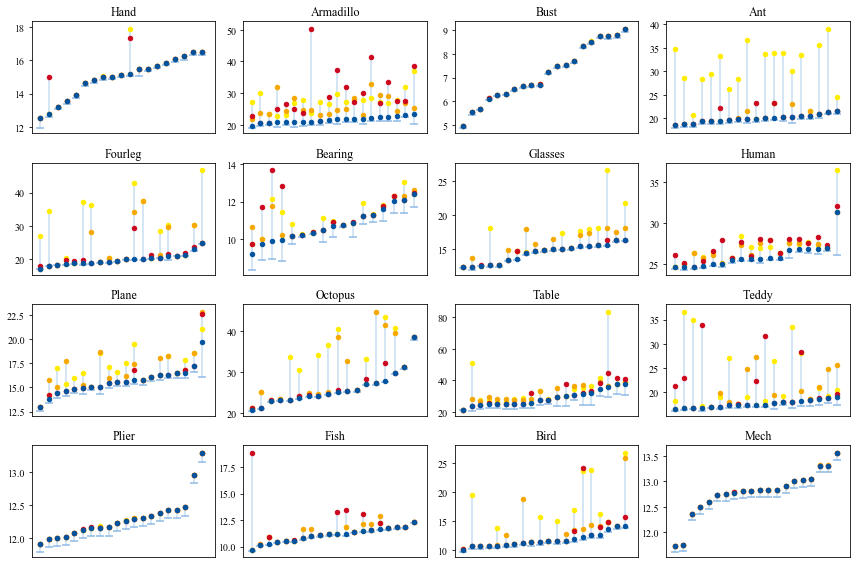

In [10]:
plt.figure(figsize=(12,8))
#plt.figure(figsize=(20,8))
subplot_index = 0
for category in shrec_categories:
    subplot_index += 1
    category_id = category['id']
    category_name = category['name']
    
    items_list = []
    for mesh_id in shrec_id_range(category_id):
        stats_fn = shrec_results_dir + f'/stats_{mesh_id}.csv'
        stats_bnb_fn = shrec_results_dir + f'/stats_{mesh_id}_bnb.csv'
        if not os.path.exists(stats_fn):
            continue
        if not os.path.exists(stats_bnb_fn):
            continue
        
        stats_data = pd.read_csv(stats_fn)
        stats_bnb_data = pd.read_csv(stats_bnb_fn)
        
        item = {}
        for ds in data_series:
            field = ds['name']
            found_entry = stats_data[(stats_data['algorithm'] == field)]
            if len(found_entry) > 0:
                item[field] = float(found_entry['score'])
        
        #item['mesh_id'] = mesh_id
        item['bnb_lower_bound'] = float(stats_bnb_data['lower_bound'])
        #item['bnb_lower_bound'] = 0.99 * item['bnb']
        
        items_list.append(item)
    num_items = len(items_list)
    if num_items == 0:
        continue
    items = pd.DataFrame(items_list)
    items.sort_values(['bnb'], ignore_index=True, inplace=True)
    
    plt.subplot(4, 4, subplot_index)
    plt.title(f'{category_name}')
    for i, row in items.iterrows():
        x = i #row['mesh_id']
        vbar_min = min([row['kraevoy'], row['praun'], row['schreiner'], row['bnb_lower_bound'], row['bnb']])
        vbar_max = max([row['kraevoy'], row['praun'], row['schreiner'], row['bnb_lower_bound'], row['bnb']])
        plt.plot([x,x], [vbar_min, vbar_max], c='rwth:blue25', zorder=-1)
        for ds in data_series:
            if ds['name'] not in row:
                continue
            y = row[ds['name']]
            marker = 'o'
            s = 20
            if ds['name'] == 'bnb_lower_bound':
                marker = '_'
                s = 60
            plt.scatter(x, y, label=ds['label'], c=ds['color'], marker=marker, s=s)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    #frame1.axes.get_xaxis().set_ticks(np.arange(items.mesh_id.min(), items.mesh_id.max() + 1, 1))
plt.tight_layout()
plt.savefig('/home/pschmidt/layout-embedding-paper/img/shrec07-quantitative/plot.pdf')

Gap below thresh: 82.8%
Last upper bound event below thresh: 97.7%
Max state tree memory: 187.2 MB


Category,#,Terminated,Gap Below Thresh,Avg Gap
Hand,19,84.2%,100.0%,1.31%
Armadillo,20,0.0%,50.0%,5.90%
Bust,20,40.0%,100.0%,1.16%
Ant,19,0.0%,94.7%,3.50%
Fourleg,20,20.0%,95.0%,1.63%
Bearing,17,17.6%,35.3%,5.48%
Glasses,19,36.8%,100.0%,1.57%
Human,18,33.3%,94.4%,2.32%
Plane,20,0.0%,90.0%,3.94%
Octopus,18,55.6%,100.0%,1.24%


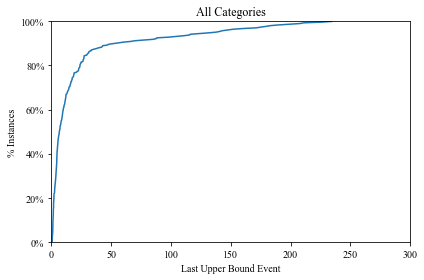

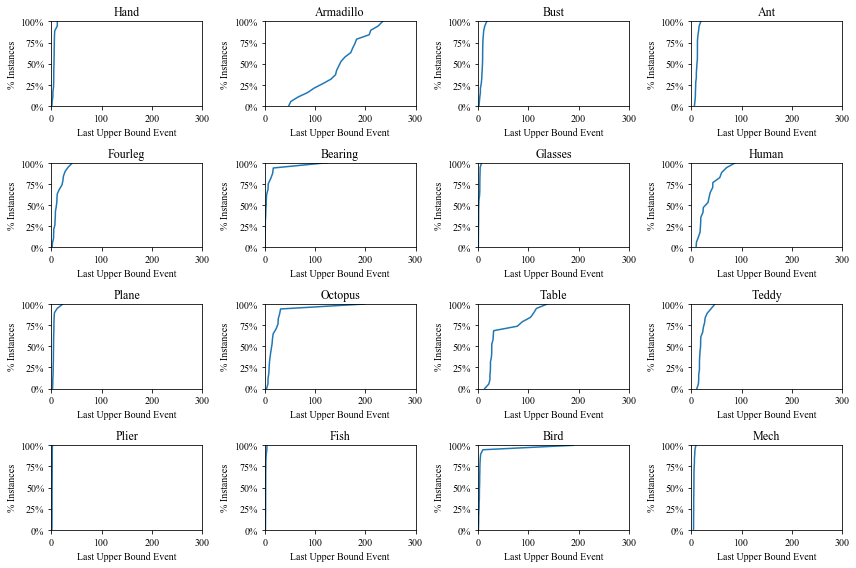

In [16]:
gap_target = 0.01
gap_thresh = 0.05
last_upper_thresh = 3 * 60 #seconds

table = [["Category", "#", "Terminated", "Gap Below Thresh", "Avg Gap"]]

gaps = []
gap_below_thresh = 0
mesh_ids_terminated = []
last_upper = []
last_upper_below_thresh = 0

gaps_per_category = {}
last_upper_per_category = {}

max_state_tree_memory = 0

for category in shrec_categories:
    category_id = category['id']
    category_name = category['name']

    category_n = 0
    category_terminated = 0
    category_gap_below_thresh = 0
    category_gap_avg = 0
    category_last_upper_avg = 0
    
    for mesh_id in shrec_id_range(category_id):
        stats_fn = shrec_results_dir + f'/stats_{mesh_id}.csv'
        stats_bnb_fn = shrec_results_dir + f'/stats_{mesh_id}_bnb.csv'
        if not os.path.exists(stats_fn):
            continue
        if not os.path.exists(stats_bnb_fn):
            continue
        
        stats_data = pd.read_csv(stats_fn)
        stats_bnb_data = pd.read_csv(stats_bnb_fn)
        
        category_n += 1
        if (stats_bnb_data['gap'].item() <= gap_target + 1e-16):
            mesh_ids_terminated.append(mesh_id)
            category_terminated += 1
            
        if (stats_bnb_data['gap'].item() <= gap_thresh):
            gap_below_thresh += 1
            category_gap_below_thresh += 1
            
        if (stats_bnb_data['last_upper_bound_event_t'].item() <= last_upper_thresh):
            last_upper_below_thresh += 1
        
        category_gap_avg += stats_bnb_data['gap'].item()
        
        gaps.append(stats_bnb_data['gap'].item())
        last_upper.append(stats_bnb_data['last_upper_bound_event_t'].item())
        
        if category_name not in gaps_per_category:
            gaps_per_category[category_name] = []
        gaps_per_category[category_name].append(stats_bnb_data['gap'].item())
        
        if category_name not in last_upper_per_category:
            last_upper_per_category[category_name] = []
        last_upper_per_category[category_name].append(stats_bnb_data['last_upper_bound_event_t'].item())
        
        max_state_tree_memory = max(stats_bnb_data['max_state_tree_memory'].item(), max_state_tree_memory)
            
    category_terminated /= category_n
    category_gap_below_thresh /= category_n
    category_gap_avg /= category_n
    category_last_upper_avg /= category_n
    
    gaps_per_category[category_name] = sorted(gaps_per_category[category_name])
    last_upper_per_category[category_name] = sorted(last_upper_per_category[category_name])
    
    table.append([
        category_name,
        category_n,
        "{:.1f}%".format(category_terminated * 100),
        "{:.1f}%".format(category_gap_below_thresh * 100),
        "{:.2f}%".format(category_gap_avg * 100),
    ])

n = len(gaps)
gap_below_thresh /= n

gaps = sorted(gaps)
last_upper = sorted(last_upper)
last_upper_below_thresh /= n

print("Gap below thresh: {:.1f}%".format(gap_below_thresh * 100))
print("Last upper bound event below thresh: {:.1f}%".format(last_upper_below_thresh * 100))
print("Max state tree memory: {:.1f} MB".format(max_state_tree_memory / 1000 / 1000))

display(HTML(tabulate.tabulate(table, tablefmt='html')))

# Global last upper bound event plot
plt.figure()
plt.title('All Categories')
plt.xlabel('Last Upper Bound Event')
plt.ylabel('% Instances')
plt.xlim(0, 300)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

percentiles = np.linspace(0, 1, n)
plt.plot(last_upper, percentiles)
plt.tight_layout()
plt.show()

# Per category last upper bound event plot
plt.figure(figsize=(12,8))
subplot_index = 0
for category in shrec_categories:
    subplot_index += 1
    category_id = category['id']
    category_name = category['name']
    
    plt.subplot(4, 4, subplot_index)
    plt.title(f'{category_name}')
    plt.xlabel('Last Upper Bound Event')
    plt.ylabel('% Instances')
    plt.xlim(0, 300)
    plt.ylim(0, 1)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    percentiles = np.linspace(0, 1, len(last_upper_per_category[category_name]))
    plt.plot(last_upper_per_category[category_name], percentiles)
    
plt.tight_layout()
plt.show()

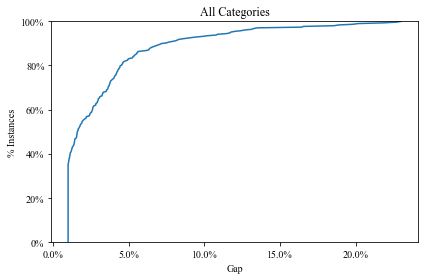

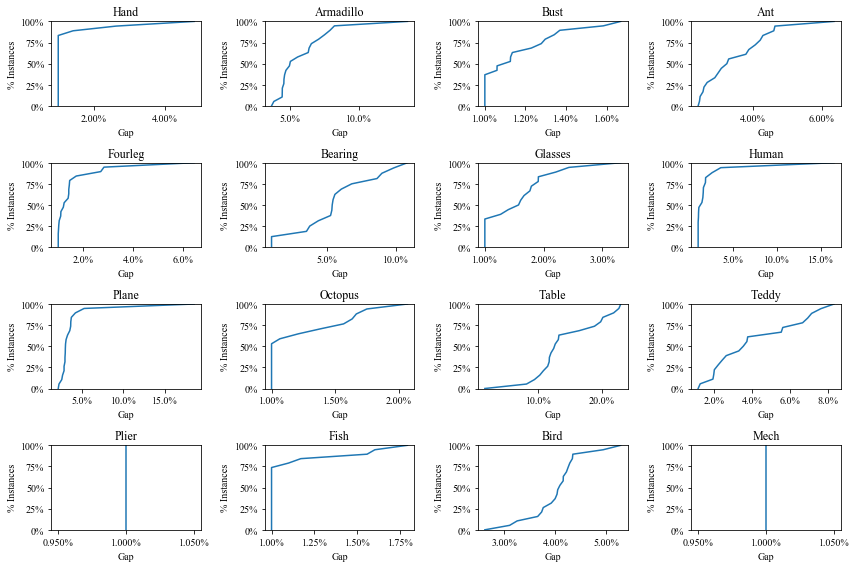

109 out of 309 runs terminated.
[1, 3, 4, 10, 11, 13, 44, 45, 46, 53, 54, 57, 58, 122, 123, 131, 132, 134, 135, 136, 137, 138, 139, 181, 182, 183, 184, 185, 186, 188, 190, 191, 192, 193, 194, 195, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 223, 224, 225, 226, 227, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 304, 305, 306, 307, 308, 310, 312, 319, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 354, 388, 391, 399, 400]


In [12]:
# Global gap plot
plt.figure()
plt.title('All Categories')
plt.xlabel('Gap')
plt.ylabel('% Instances')
plt.ylim(0, 1)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

percentiles = np.linspace(0, 1, n)
plt.plot(gaps, percentiles)
plt.tight_layout()
plt.show()

# Per category gap plot
plt.figure(figsize=(12,8))
subplot_index = 0
for category in shrec_categories:
    subplot_index += 1
    category_id = category['id']
    category_name = category['name']
    
    plt.subplot(4, 4, subplot_index)
    plt.title(f'{category_name}')
    plt.xlabel('Gap')
    plt.ylabel('% Instances')
    plt.ylim(0, 1)
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    percentiles = np.linspace(0, 1, len(gaps_per_category[category_name]))
    plt.plot(gaps_per_category[category_name], percentiles)

    #frame1 = plt.gca()
    #frame1.axes.get_xaxis().set_ticks(np.arange(gaps_per_category[category_name].min, items.mesh_id.max() + 1, 1))
    
plt.tight_layout()
plt.show()

print("{} out of {} runs terminated.".format(len(mesh_ids_terminated), n))
print(sorted(mesh_ids_terminated))

NameError: name 'cases' is not defined

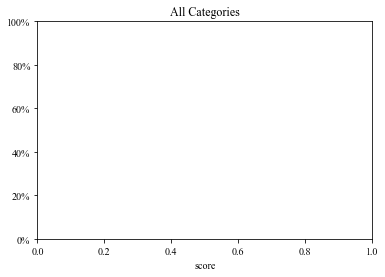

In [4]:
plt.figure()
plt.title('All Categories')
plt.xlabel('score')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylim(0, 1)
for case in cases:
    algo = case['algo']
    ascending_score = np.sort(run_data.loc[algo]['score'])
    percentiles = np.linspace(0, 1, len(ascending_score))
    plt.plot(ascending_score, percentiles, label=case['label'], c=case['color'])
plt.legend(loc='lower right')

In [ ]:
run_data.set_index(['id'])

In [ ]:
plt.figure(figsize=(12,18))
subplot_index = 1
for c in categories:
    id_min = 1 + (c['id'] - 1) * 20
    id_max = 1 + c['id'] * 20
    c_data = run_data[run_data.index.get_level_values('id').isin(range(id_min, id_max))]
    if len(c_data) == 0:
        continue
    plt.subplot(6, 3, subplot_index)
    name = c['name']
    plt.title(f'{name} ({id_min}–{id_max})')
    plt.xlabel('score')
    
    for c_id in c_data['id']:
        print(f'id: {id}')
    
    subplot_index += 1
plt.tight_layout()

In [ ]:
plt.figure(figsize=(12,18))
subplot_index = 1
for c in categories:
    id_min = 1 + (c['id'] - 1) * 20
    id_max = 1 + c['id'] * 20
    c_data = run_data[run_data.index.get_level_values('id').isin(range(id_min, id_max))]
    if len(c_data) == 0:
        continue
    plt.subplot(6, 3, subplot_index)
    name = c['name']
    plt.title(f'{name} ({id_min}–{id_max})')
    plt.xlabel('score')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.ylim(0, 1)
    for case in cases:
        algo = case['algo']
        ascending_score = np.sort(c_data.loc[algo]['score'])
        percentiles = np.linspace(0, 1, len(ascending_score))
        plt.plot(ascending_score, percentiles, label=case['label'], c=case['color'])
    plt.legend(loc='lower right')
    subplot_index += 1
plt.tight_layout()

In [5]:
cases = [
    {
        'algo': 'greedy',
        'label': 'Greedy',
        'color': 'rwth:red',
    },
    {
        'algo': 'greedy_brute_force',
        'label': 'Greedy (Brute Force)',
        'color': 'rwth:orange',
    },
    {
        'algo': 'bnb',
        'label': 'Branch-and-Bound',
        'color': 'rwth:blue',
    },
]

for case in cases:
    algo = case['algo']
    runtime_series = run_data.loc[algo]['runtime'].dropna()
    ascending_runtime = np.sort(runtime_series)
    percentiles = np.linspace(0, 1, len(ascending_runtime))

    plt.figure()
    plt.title(case['label'])
    plt.xlabel('runtime (s)')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.ylim(0, 1)
    if algo == 'bnb':
        plt.axvline(600, c='lightgray', linestyle='--', zorder=-1)
    plt.plot(ascending_runtime, percentiles, c=case['color'])
    
    print('avg {}: {} s'.format(algo, runtime_series.mean()))

NameError: name 'run_data' is not defined